In [1]:
import scvi
import scanpy as sc
import os
import numpy as np
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import pandas as pd
import hdf5plugin

import warnings
warnings.filterwarnings("ignore")

### Data integration & batch effects

- Θέλουμε να συνενώσουμε σύνολα δεδομένων γονιδιακής έκφρασης σε ένα ενιαίο μεγαλύτερο σύνολο δεδομένων (βελτίωση στατιστικής σημαντικότητας αποτελεσμάτων, περισσότερα δείγματα για αλγορίθμους μηχανικής μάθησης, κλπ).

- Στις περισσότερες των περιπτώσεων, ένα σύνολο δεδομένων γονιδιακής έκφρασης χωρίζεται σε επιμέρους υποσύνολα/πακέτα έτσι ώστε να γίνει πιο εύκολη η διαδικασία αλληλούχισης.

- Batch effects: μη επιθυμητές τεχνικές διακυμάνσεις στα δεδομένα οι οποίες είναι αποτέλεσμα της διαίρεσης ενός συνόλου δεδομένων σε επιμέρους υποσύνολα/πακέτα. Σε κάποιες περιπτώσεις, ακόμα και βιολογικοί παράγοντες (π.χ: ιστός δείγματος, είδος οργανισμούς, κλπ) μπορεί να θεωρηθούν ως batch effect.

- Τα batch effects "μπερδεύονται" με την βιολογική πληροφορία ενδιαφέροντος που υπάρχει στα δεδομένα μας. Επομένως, μπορεί να οδηγήσουν σε λανθασμένα συμπεράσματα για το βιολογικό φαινόμενο το οποίο μελετάμε.

- Σκοπός του data integration: να γίνει συγχώνευση των προς μελέτη επιμέρους συνόλων δεδομένων/πακέτων και στη συνέχεια μοντελοποίηση και κατ' επέκταση φιλτράρισμα των batch effects από το τελικό/ενιαίο σύνολο δεδομένων.

- Η διαδικασία αυτή γίνεται με τέτοιο τρόπο έτσι ώστε κύτταρα τα οποία ανήκουν σε διαφορετικά πακέτα δεδομένων/batches αλλά είναι βιολογικά παρόμοια (π.χ: ανήκουν στον ίδιο κυτταρικό τύπο), να είναι όσο πιο κοντά σε έναν χώρο μειωμένης διατατικότητας γίνεται.

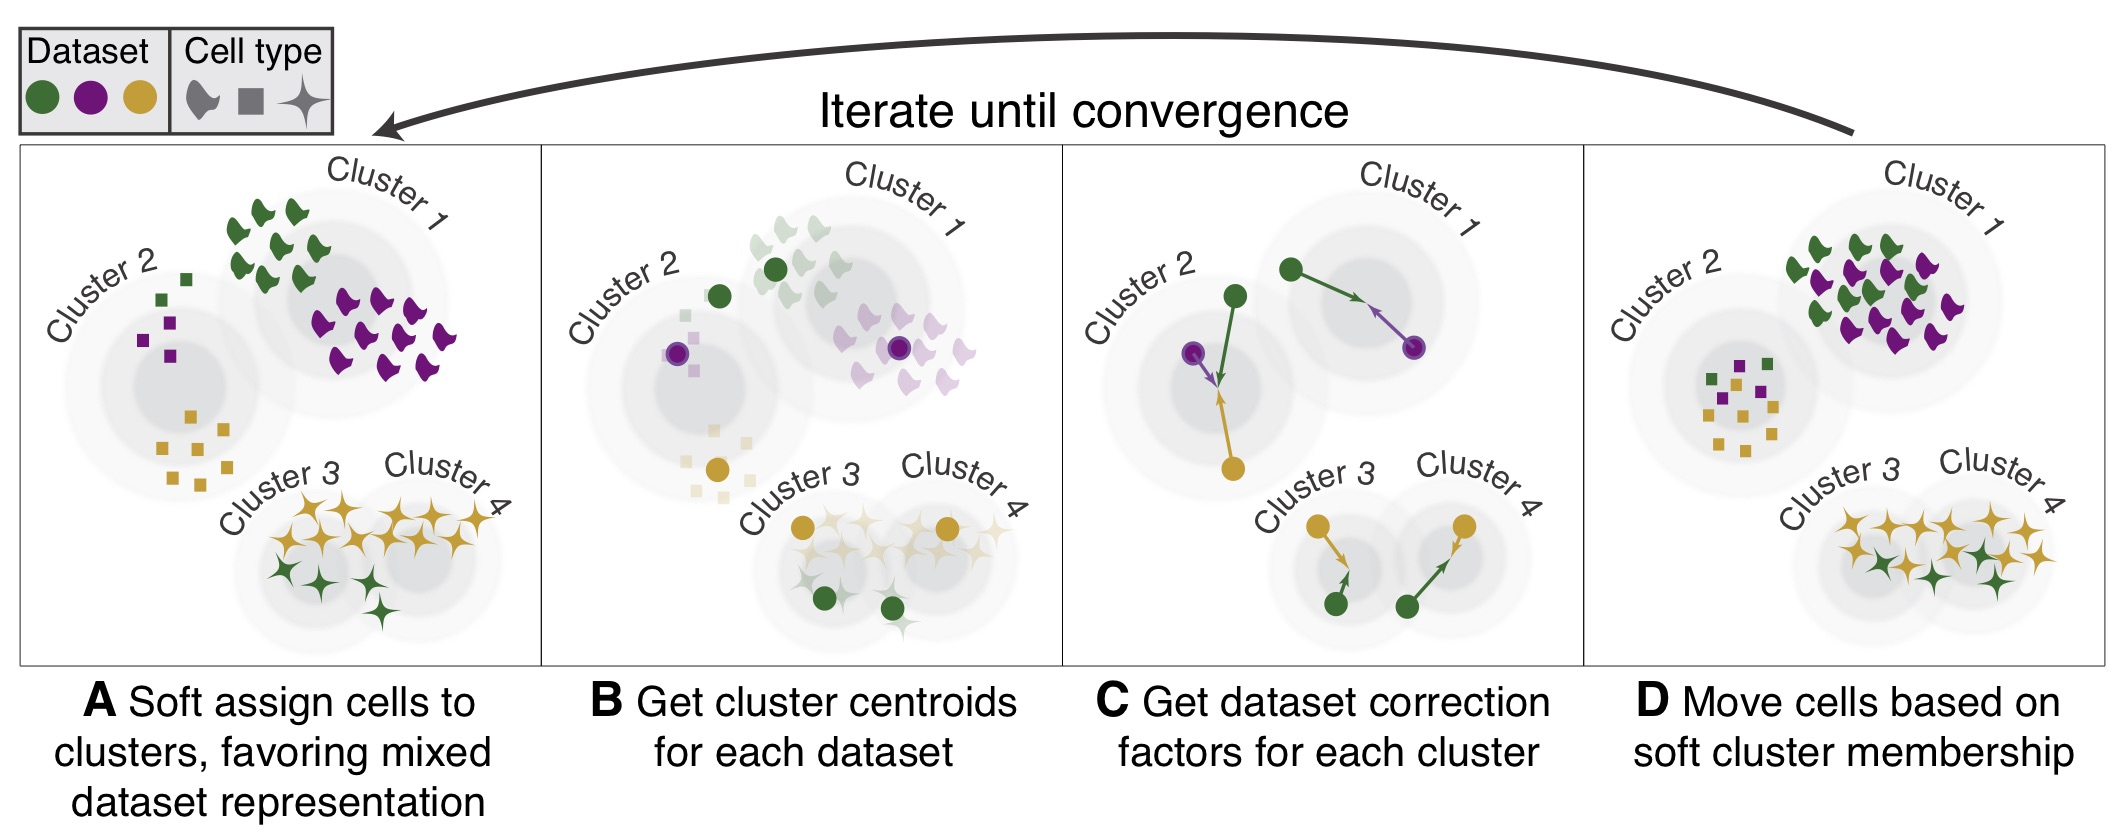

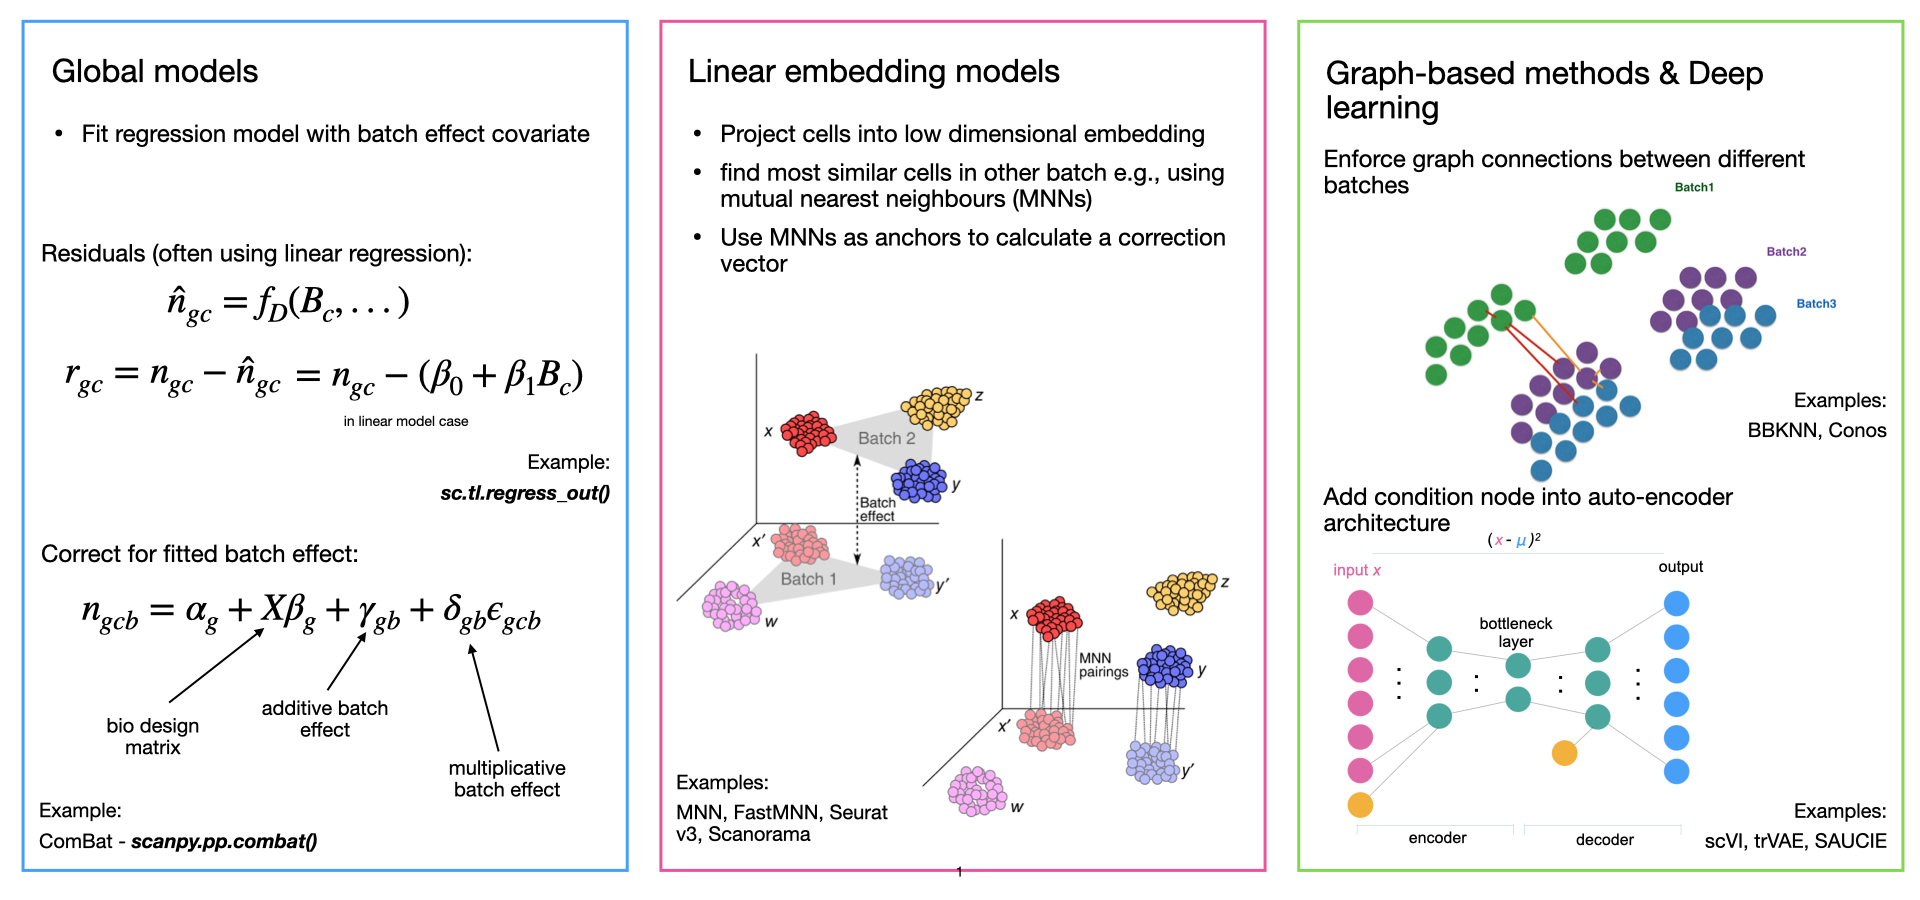

In [2]:
VERSION = "1"

In [3]:
def scale_and_neigh(adata, neigh="no"):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    if neigh == "yes":
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)
    return adata

### Read & preprocess data for visualization (before integration)

In [4]:
merged_adata_vis = sc.read_h5ad("./data/5.H5AD_concatenated/alzheimer_data_concat_v1.h5ad")
merged_adata_vis
# merged_adata_vis = scale_and_neigh(merged_adata_vis, "yes")

AnnData object with n_obs × n_vars = 12626 × 19965
    obs: 'batch', 'condition', 'n_genes', 'prc_mt', 'prc_rb', 'n_counts', 'doublet', 'batch_num'
    var: 'gene_ids'

In [6]:
merged_adata_vis.obs["condition"].value_counts()

Alzheimer    7797
Control      4829
Name: condition, dtype: int64

In [ ]:
sc.pl.umap(
    merged_adata_vis, 
    color='batch', 
    add_outline=True,
    legend_fontsize=12, 
    legend_fontoutline=2,
    frameon=False, 
    title='Before Integration', 
    show=False
)

plt.savefig("./figures/alz_data_concat_batch.png", bbox_inches="tight", dpi=300)

In [ ]:
sc.pl.umap(
    merged_adata_vis, 
    color='condition', 
    add_outline=True,
    legend_fontsize=12, 
    legend_fontoutline=2,
    frameon=False, 
    title='Before Integration', 
    show=False
)

plt.savefig("./figures/alz_data_concat_condition.png", bbox_inches="tight", dpi=300)

### Read & scale data (preparation for integration with scVI)

In [ ]:
adata = sc.read_h5ad("./data/5.H5AD_concatenated/alzheimer_data_concat_v1.h5ad")
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension safe

In [ ]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

In [ ]:
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30)

In [ ]:
scvi_model.train()

In [ ]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [ ]:
adata

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scVI")
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color='batch', add_outline=True,
           legend_fontsize=12, legend_fontoutline=2,frameon=False, title='scVI Integration', show=False)

plt.savefig('./figures/umap_scVI_integration_batch.png', dpi=600, bbox_inches='tight')

In [ ]:
sc.pl.umap(adata, color='condition', add_outline=True,
           legend_fontsize=12, legend_fontoutline=2,frameon=False, title='scVI Integration', show=False)

plt.savefig('./figures/umap_scVI_integration_condition.png', dpi=600, bbox_inches='tight')

In [ ]:
adata.write_h5ad(
    f"./data/6.H5AD_integrated/scVI_integration_v{VERSION}.h5ad",
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)